# The Cross Resonance (CR) Gate

Here's what we'll work through in this tutorial notebook:

*  Introduce and describe the basic operation of the cross-resonance (CR) gate 
*  Construct the time-dependent Hamiltonian of a representative CR gate consisting of two qubits coupled via a CPW resonator. 
*  Look at the time-evolution of the two qubits in a CR gate 
*  Show how to build a representative physical design of a CR gate using qiskit metal. 

### What is the CR Gate?

The cross-resonance (CR) gate consists of two fixed-frequency qubits connected via a resonator. One of the qubits (the "control" qubit) is driven at the transition frequency of the second qubit (the "target" qubit) which results in Rabi oscillations in the target qubit. 

Some helpful background papers on the CR gate: 

* C. Rigetti and M. Devoret, Phys. Rev. B 81, 134507 (2010)
* M. Malekakhlagh et al., Phys. Rev. A 102, 042605 (2020)
* E. Magesan and J.M. Gambetta, Phys. Rev. A 101, 052308 (2020)


### What does the Hamiltonian of the CR gate look like? 

We can composite Hamiltonian of the CR gate consists of the non-interacting Hamiltonians of the two qubits, a coupling term between the two qubits and the drive term applied to the control qubit:

$H = H_{Q1} + H_{Q2} + H_{Coupling} + H_{Drive}   $ 

where $H_{Coupling}$ is the coupling between qubit 1 and qubit 2, and $H_{Drive}$ is the driving microwave signal applies to qubit 1 (at the frequency of qubit 2). The first three terms are time-independent while the drive term has time-dependence in the form a cosine wave. 

In a simplistic approach using Pauli matrices ($\sigma_z = a^{+}a $ , $\sigma_x = a + a^{+} $) for each qubit, we can write the individual components as follows:

$H_{Q1} = 0.5 \omega_1 \sigma_1^{z} $

$H_{Q2} = 0.5 \omega_2 \sigma_2^{z} $

$H_{Coupling} = 0.5 \omega_{xx} \sigma_1^{x} \sigma_2^{x}$

$H_{Drive} = \Omega cos(\omega_1^{RF} t + \phi) \sigma_1^{x}   $

By setting $\omega_1^{RF} = \omega_2$, we are driving qubit 1 at the frequency of qubit 2. 

The full Hamiltonian can thus be written as: 

$H = 0.5 \omega_1 \sigma_1^{z} + 0.5 \omega_2 \sigma_2^{z} + 0.5 \omega_{xx} \sigma_1^{x} \sigma_2^{x} +  \Omega cos(\omega_1^{RF} t + \phi) \sigma_1^{x}  $

### Constructing the CR Gate Hamiltonian Using QuTiP & Qiskit Metal 

Let's start by loading the required modules:

In [ ]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy = True
%matplotlib inline
%config Completer.use_jedi = False
%config InlineBackend.figure_format = 'svg'

from qiskit_metal.analyses.hamiltonian.transmon_charge_basis import Hcpb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
from math import *

The CR gate uses fixed-frequency qubits, so we'll define the two qubit frequencies as well as the coupling strength between them. We'll use similar values to those published in the original CR gate paper from Rigetti & Devoret: 

In [ ]:
w1 = 12.8
w2 = 16.1
g=0.13

Now, let's define the initial states of the two qubits and then construct the tensor product for the composite wavefunction of the initial state. We'll consider two states for each qubit, hence we'll use "basis(2,N)" where N represents the index of the state. 

In [ ]:
# Initial States of Qubit1 and Qubit2 
Psi1_initial = basis(2,0) # ground state of qubit 1
Psi2_initial = basis(2,1) # excited state of qubit 2 

# Tensor Product of Composite Initial Wavefunction 
Psi0 = tensor(Psi1_initial, Psi2_initial)

### Time-independent Hamiltonian

Now let's build the operators that will go into the Hamiltonian. Notice that the two tensor products below have the location of the identity matrix ("qeye") swapped, since in the first case we're writing the operator for qubit 1 in the basis of qubit 2, and the second case we're writing the operator for qubit 2 in the basis of qubit 1. 

In [ ]:
# ladder operator for qubit 1 ("a")
a  = tensor(destroy(2), qeye(2))

# ladder operator for qubit 2 ("b")
b = tensor(qeye(2), destroy(2))

Now let's construct the tensor products for occupation probability operators (for n=0 and n=1) for each qubit. 

In [ ]:
# QUBIT 1 

# this defines the ground state |n=0> 
c0 = basis(2,0)
# now take the product |n=0><n=0| 
n0_qubit1 = c0*c0.dag()
# and lastly the tensor product in the basis of qubit 2
n0_qubit1 = tensor(n0_qubit1, qeye(2))

# this defines the first excited state |n=1>
c1 = basis(2,1)
# take the product |n=1><n=1| 
n1_qubit1 = c1*c1.dag()
# and lastly the tensor product in the basis of qubit 2
n1_qubit1 = tensor(n1_qubit1, qeye(2))

# QUBIT 2
# (same operations as above)

c0 = basis(2,0)
n0_qubit2 = c0*c0.dag()
n0_qubit2 = tensor(qeye(2),n0_qubit2)

c1 = basis(2,1)
n1_qubit2 = c1*c1.dag()
n1_qubit2 = tensor(qeye(2),n1_qubit2)

Now we can build the time-independent Hamiltonian of the two-qubit system and verify that it is a 4x4 matrix describing two qubits each with their own 2x2 non-interacting Hamiltonians:

In [ ]:
# time independent Hamiltonian
H0 = w1*a.dag()*a + w2*b.dag()*b + g*(a+a.dag())*(b+b.dag())
H0

### Time Evolution of the Time-Independent Hamiltonian

Even though our Hamiltonian is time-independent (missing the time-dependent driving term), the interaction term between the two qubits will still give some non-trivial time evoluation. 

We can use the master equation solver in QuTiP to solve for the time evolution, giving Hamiltonian H0 and initial state Psi0 that we've defined above. As output, we'll calculate the occupation probabilities of each qubit at each timestep. 

In [ ]:
tlist = tlist = np.linspace(0,25,101)    # time between t=0 and t=25 with 101 increments 
dissipation = []   # no dissipation
#output = mesolve(H0, Psi0, tlist, c_ops, [n0_qubit1, n1_qubit1, n0_qubit2, n1_qubit2]) # time evolution
output = mesolve(H0, Psi0, tlist, dissipation , [n0_qubit1, n1_qubit1, n0_qubit2, n1_qubit2]) # time evolution

n0_qubit1 = output.expect[0]
n1_qubit1 = output.expect[1] 
n0_qubit2 = output.expect[2]
n1_qubit2 = output.expect[3] 

Let's plot the occupation probabilities for the n=0 and n=1 states of each qubit. 

In [ ]:
plt.figure(1, figsize=(10,5))
plt.subplot(121)
plt.plot(tlist,n0_qubit1, label="n=0")
plt.plot(tlist,n1_qubit1, label="n=1")
plt.legend(loc=0)
plt.xlabel("Time")
plt.ylabel("Occupation Probability") 
plt.title("Qubit1")

plt.subplot(122)
plt.plot(tlist,n0_qubit2, label="n=0")
plt.plot(tlist,n1_qubit2, label="n=1")
plt.legend(loc=0)
plt.xlabel("Time")
plt.ylabel("Occupation Probability")
plt.title("Qubit2")

We see that qubit1 is in the ground state (n=0) while qubit 2 is the first excited state (n=1) just as we had defined earlier. Note the the slight oscillations in occupation probability, which would be absent without the coupling term in the Hamiltonian. 

### Adding Time-Dependence to the Hamiltonian

Now we will add the time-dependent term to the Hamiltonian representing the operation of a CR gate. We will add a drive term to qubit 1, driving at the frequency of qubit 2. Recall that the drive term has the form: 

$H_{Drive} = \Omega cos(\omega_1^{RF} t + \phi) \sigma_1^{x}   $

In [ ]:
amp = 0.5 # amplitude of driving force (Omega)
phi = 0.0 # set the phase equal to zero

H_drive = amp*(a+a.dag())  # this is the time-independent part of the driving term 

# add the explicit time-dependence here: 
def H_time(t, args=None):
    return np.cos(w2*t + phi)

# combine time-independent and time-dependent terms:
H = [H0,[H_drive, H_time]]

Since we already defined, populated and plotted the occupation operators in the time-independent analysis above, let's re-define them here:

In [ ]:
# Re-define our occupation probability operators

c0 = basis(2,0)
n0_qubit1 = c0*c0.dag()
n0_qubit1 = tensor(n0_qubit1, qeye(2))

c1 = basis(2,1)
n1_qubit1 = c1*c1.dag()
n1_qubit1 = tensor(n1_qubit1, qeye(2))

c0 = basis(2,0)
n0_qubit2 = c0*c0.dag()
n0_qubit2 = tensor(qeye(2),n0_qubit2)

c1 = basis(2,1)
n1_qubit2 = c1*c1.dag()
n1_qubit2 = tensor(qeye(2),n1_qubit2)

Now let's solve the master equation again for the time-dependent Hamiltonian:

In [ ]:
tlist = tlist = np.linspace(0,201,101) # time between t=0 and t=201 with 101 increments 
c_ops = []  # dissipation terms; none 
output = mesolve(H, Psi0, tlist, c_ops, 
                 [n0_qubit1, n1_qubit1, a.dag()*a, a+a.dag(), n0_qubit2, n1_qubit2, b.dag()*b, b+b.dag()]) # time evolution

# expectation values
n_qubit1 = output.expect[0]
m_qubit1 = output.expect[1]
ham_qubit1 = output.expect[2] 
num_qubit1 = output.expect[3] 

n_qubit2 = output.expect[4]
m_qubit2 = output.expect[5]
ham_qubit2 = output.expect[6]
num_qubit2 = output.expect[7]

And now let's plot the results again:

In [ ]:
plt.figure(1, figsize=(10,5))
plt.subplot(121)
plt.plot(tlist,n_qubit1, label="n=0")
plt.plot(tlist,m_qubit1, label="n=1")
plt.legend(loc=0)
plt.xlabel("Time")
plt.ylabel("Occupation Probability") 
plt.title("Qubit1")

plt.subplot(122)
plt.plot(tlist,n_qubit2, label="n=0")
plt.plot(tlist,m_qubit2, label="n=1")
plt.legend(loc=0)
plt.xlabel("Time")
plt.ylabel("Occupation Probability")
plt.title("Qubit2")

Here we can see that by applying a driving force to the first qubit, we observe an inversion in the occupation probability of the second qubit. This highlights the basic operational principle of the CR gate. 

## Physical Design of the CR Gate 

The physical design of a CR gate consists simply of two qubits connected via a bus resonator. For a concrete example of what this design may look like, we can use the example in H. Park et al. Proc. IEEE IEDM (2020). 

Link: https://ieeexplore.ieee.org/abstract/document/9371955?casa_token=V3vN91zwr4EAAAAA:OwS7ixnZTFZlL0mnIf5idc5l0P_sufOJAnEh0TLxPZ7HB6EJAwS2Y-XVrW3j5R3-gifZrX6JF63Azg

This paper shows show different designs for a CR-gate. We'll construct a design very similar to the first one. 

Let's open up the qiskit metal design GUI:

In [1]:
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, open_docs

While one could construct a CR gate using any transmon qubit design, we'll use the generic transmon pocket to be consistent with the paper:

In [2]:
from qiskit_metal.qlibrary.qubits.transmon_pocket_6 import TransmonPocket6
design = metal.designs.DesignPlanar()
gui = metal.MetalGUI(design)

In [3]:
design.overwrite_enabled = True
design.chips.main

{'material': 'silicon',
 'layer_start': '0',
 'layer_end': '2048',
 'size': {'center_x': '0.0mm',
  'center_y': '0.0mm',
  'center_z': '0.0mm',
  'size_x': '9mm',
  'size_y': '6mm',
  'size_z': '-750um',
  'sample_holder_top': '890um',
  'sample_holder_bottom': '1650um'}}

For each of the two transmon qubits, we'll include two capacitively coupled pads ("readout" and "bus"). We'll put one of htem at (-1,0) and the other at (1,0) with the second one being rotated 90 degrees relative to the first. 

In [4]:
Q1 = TransmonPocket6(design,'Q1',options =  dict(
    pos_x='-1mm',
    pos_y='0mm',
    pad_width = '425 um', 
    pocket_height = '650um',
    connection_pads=dict(
        readout = dict(loc_W=1, loc_H=-1, pad_width = '100um', pad_gap = '50um'),
        bus_01 = dict(loc_W=1, loc_H=1, pad_width = '100um', pad_gap = '50um'),       
    ))
                    )

Q2 = TransmonPocket6(design,'Q2',options =  dict(
    pos_x='1mm',
    pos_y='0mm',
    orientation=-90,
    pad_width = '425 um', 
    pocket_height = '650um',
    connection_pads=dict(
        readout = dict(loc_W=-1, loc_H=-1, pad_width = '100um', pad_gap = '50um'),
        bus_01 = dict(loc_W=-1, loc_H=1, pad_width = '100um', pad_gap = '50um'),       
    ))
                    )


gui.rebuild()
gui.autoscale()

Here's a screenshot showing the two qubits:

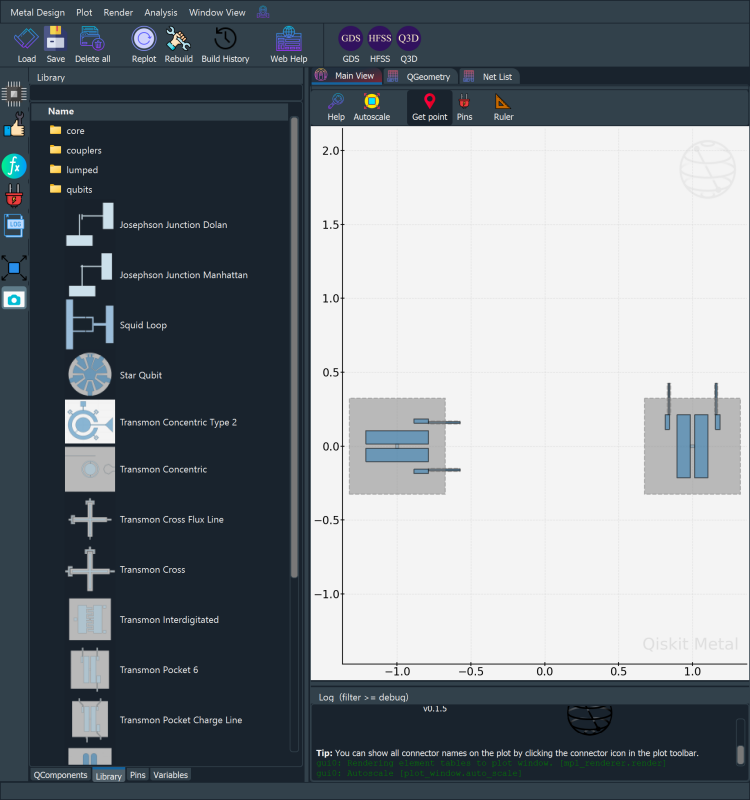

In [5]:
gui.screenshot()

Now we just have to connect these two transmon qubits with a CPW. We'll use the RouteMeader to do this, connecting the "readout" island of the first qubit to the "readout" island of the second qubit. We'll also specify a series of left-hand and right-hand turns in order to mimc the shape of the CPW resonator that we see in the paper: 

In [6]:
from qiskit_metal.analyses.em.cpw_calculations import guided_wavelength
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.tlines.anchored_path import RouteAnchors

from collections import OrderedDict
jogs_start = OrderedDict()
jogs_start[0] = ["R", '1200um']
jogs_start[1] = ["R", '200um']
jogs_start[2] = ["R", '700um']
jogs_start[3] = ["L", '200um']
jogs_start[4] = ["L", '700um']
jogs_start[5] = ["R", '200um']
jogs_start[6] = ["R", '750um']
jogs_start[7] = ["L", '200um']
jogs_start[8] = ["L", '1200um']
jogs_start[9] = ["L", '1800um']
jogs_start[10] = ["L", '2500um']

jogs_end = OrderedDict()
jogs_end[0] = ["R", '200um']

bus_01 = RouteMeander(design,'Coupler', options = dict(hfss_wire_bonds = True, 
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q1',
                                                    pin='readout'),
                                                end_pin=Dict(
                                                    component='Q2',
                                                    pin='readout')
                                            ),
                                            lead=Dict(
                                                start_straight='100um',  #'125um',
                                                start_jogged_extension=jogs_start,
                                                end_straight = '100um'        #  '225um'
                                            ),
                                                       
                                            meander=Dict(
                                                asymmetry ='0um'), #'1305um'),
                                            fillet = "99um",
                                            total_length = '10mm'))
gui.rebuild()

And here's a screenshot showing the meandering CPW connection:

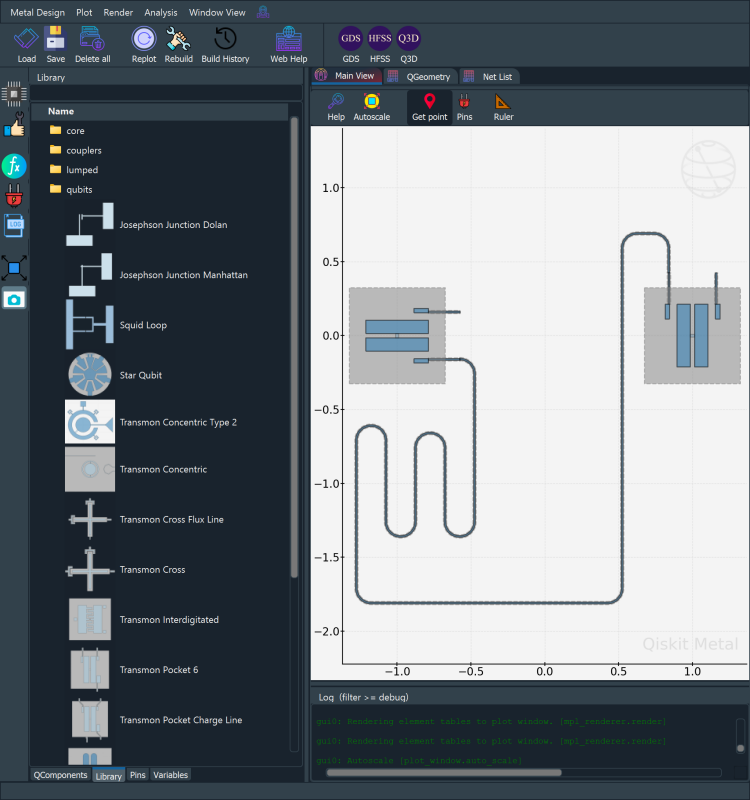

In [7]:
gui.rebuild()
gui.autoscale()
gui.screenshot()

Voila! Now you know not only how a CR gate behaves physically but what it looks like in physical design! 